# Todos os imports e bibliotecas que precisam ser instaladas para rodar a Questão 1 e 2 da prova estão aqui

In [2]:
# %pip install pyspellchecker torch transformers scikit-learn spacy pandas numpy seaborn
import numpy as np
import pandas as pd
import re
import string
import spacy
from spellchecker import SpellChecker
from collections import Counter
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\tavin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Aqui eu leio o data set e já começo o pré-processamento arrumando a coluna de data, formatando-a corretamente e ignorando possíveis atualizações
# Questão (1)
## Explicação dos Atributos
### O dataset foi carregado a partir de um arquivo Excel (FakeRecogna_noremoval_words.xlsx). Alguns atributos foram removidos (Autor, Subtitulo, URL), e os seguintes atributos principais permaneceram:
- Titulo: O título da notícia.
- Noticia: O conteúdo textual da notícia.
- Dias_desde_publicacao: A distância em dias do dia atual a data da publicação da notícia. // Após ser preprocessada
- embedding: Representação numérica gerada pelo modelo BERT, que captura o significado semântico das notícias.

## Atributo-meta **Classe** (Saída)
### O atributo meta trata-se da última coluna da tabela classe, no qual 0 é para fake news e 1 é para notícia real
- Fake 0
- Real 1

## Motivação para a escolha do problema
### O problema abordado é um problema de classificação, onde o objetivo é treinar um modelo para identificar notícias falsas com base em suas características textuais. A motivação vem do impacto social, já que me português poucos estudos foram feitos para criar sistemas de detecção de fake news, assim, com um modelo bem sucedido podemos ajudar diversas pessoas que não entendem ou não conseguem discernir entre uma notícia falsa e verdadeira


In [ ]:
df = pd.read_excel("C:/Users/tavin/Desktop/FakeRecogna_noremoval_words.xlsx")
df = df.drop(columns=["Autor", "Subtitulo", "URL"], errors="ignore")

def extract_date(text):
    match = re.search(r"\b\d{1,2}/\d{1,2}/\d{4}\b", str(text))
    return match.group(0) if match else None

df["Data"] = df["Data"].apply(extract_date)
df["Data"] = df["Data"].fillna("Data desconhecida")

# Etapa de Pré-Processamento propriamente dita
## 1. Converto todos os valores de texto para lowercase

In [ ]:
df[['Titulo', 'Noticia']] = df[['Titulo', 'Noticia']].apply(lambda x: x.str.lower())
df.sample(frac=1)

,Titulo,Noticia,Categoria,Data,Classe
9569,salvador: escudeiros do pt e franco-atiradores...,ausentar disputar prefeitura salvador o govern...,política,02/10/2020,1
4157,é #fake que vacina contra covid-19 é inócua po...,circular rede social mensagem relativizar o im...,saúde,02/02/2021,0
4680,'wolverine' mostra garra e supera internação d...,wolverine causar semelhança o personagem quadr...,saúde,15/07/2020,1
6491,é falso que a atriz maria flor recebeu r$ 10 m...,falso o posts apresentar o foto atriz maria fl...,política,Data desconhecida,0
4341,\n não há evidências de que chá de boldo cure...,“ governar gastar bilião combater o o corona v...,brasil,18/05/2020,0
...,...,...,...,...,...
10798,veja o que é #fato ou #fake nas declarações do...,candidato prefeitura paulo continuidade campan...,política,17/10/2020,0
6564,o que fazer sem salão na pandemia? rodrigo cin...,tutorial o internet ensinar o mudar o fio pari...,saúde,26/05/2020,1
14,é impossível que vacina cause alterações genét...,haver comprovação vacinar o covid-19 modificar...,saúde,Data desconhecida,0
5946,disseminação do coronavírus na amazônia faz mo...,anthony boadle e stephen eisenhammer brasília ...,saúde,04/06/2020,1


## 2. Aqui nós removemos todos os ponto, vírgulas e caracteres que se enquadram nessa descrição

In [ ]:
def remove_punctuations(text):
  punctuations = string.punctuation
  if isinstance(text, str):  # Verifica se é uma string
    return text.translate(str.maketrans("", "", string.punctuation))
  return text

df[['Titulo', 'Noticia']] = df[['Titulo', 'Noticia']].apply(lambda x: remove_punctuations(x))
df.sample(frac=1)

,Titulo,Noticia,Categoria,Data,Classe
9275,"\n\nbreno lintz, promotor de justiça em uberlâ...",página compartilhar o gostar e acreditar atenç...,política,27/04/2020,0
8035,paciente nos eua passou quatro dias sem fazer ...,paciente eua suspeitar covid-19 passar dia pas...,saúde,27/02/2020,1
8569,bolsonaristas provocam mbl após prisão de empr...,representante bolsonarismo e apoiadores presid...,política,11/07/2020,1
9858,post engana ao dizer que exército construiu po...,o vídeo apresentar real e militar levar semana...,política,Data desconhecida,0
9832,"doria presta solidariedade a moro: ""lava jato ...",o governador paulo joão doria psdb prestar sol...,política,24/03/2021,1
...,...,...,...,...,...
6250,advogado de lula lamenta falta de punição em c...,o advogar ex-presidente luiz inácio lula silva...,política,25/08/2020,1
9962,\n\nbolsonaro acaba anunciar sua renúncia por ...,urgente bolsonaro acabar anunciar palácio plan...,política,01/04/2020,0
2107,\n\nbandidos se cadastram como motorista de ap...,“ informação importante o quantidade preso par...,brasil,10/07/2019,0
2649,\n\nministro sérgio moro pode ter a prisão dec...,morar prisão decretar stf o congresso nacional...,política,26/12/2019,0


## 3. Aqui removi outros caracteres especiais e \n que estava poluindo os texto e os títulos

In [ ]:
ESPECIAIS = np.array(["“", "”", "\n"], dtype=str)

def remove_freq_words(text):
  return " ".join([word for word in text.split() if word not in ESPECIAIS])

df['Noticia'] = df['Noticia'].apply(lambda x: remove_freq_words(x))
df['Titulo'] = df['Titulo'].fillna("")

def remove_freq_words(text):
  return " ".join([word for word in text.split() if word not in ESPECIAIS])

df['Titulo'] = df['Titulo'].apply(lambda x: remove_freq_words(x))

df.sample(frac=1)

,Titulo,Noticia,Categoria,Data,Classe
6507,fala da oms é tirada de contexto para dizer qu...,enganoso o afirmação o oms organização mundial...,saúde,06/05/2020,0
2860,"ao falar de covid-19, bolsonaro volta a usar d...",o presidente jair bolsonaro voltar o declaraçã...,saúde,08/07/2020,0
895,brasil pode se tornar um dos epicentros da pan...,o brasil tornar epicentro pandemia global coro...,saúde,12/05/2020,1
9599,"alvo de bolsonaro, noruega subiu quota de caça...",reação suspensão repasse o fundir amazônia nor...,mundo,23/08/2019,0
2098,gene kelly se inspirou no frevo de recife para...,gene kelly ator principal premiadíssimo filmar...,entretenimento,16/02/2021,0
...,...,...,...,...,...
10848,"argentina reduz voos para brasil, méxico, esta...",o governar argentino ordenar s companhia aéreo...,saúde,27/01/2021,1
10778,olavo diz que foi censurado; youtube pede que ...,o escritor olavo carvalho escrever redar socia...,política,17/11/2020,1
602,joice hasselmann se feriu em um acidente após ...,imagem começar o espalhar julho deputar federa...,entretenimento,26/07/2021,0
6102,brasil tem 1.300 mortes por coronavírus em 24 ...,o brasil 1.300 morte registrar razão coronavír...,ciência,10/06/2020,1


## 4. Removeremos aqui tudo o que não e letra, número, assento ou -

In [7]:
#4. Remove of Special characters
def remove_spl_chars(text):
  text = re.sub('[^a-zA-Z0-9áéíóúàèìòùâêîôûãõäëïöüç-]'," ", text)
  text = re.sub('\s+', " ", text)
  return text

df["Noticia"] = df["Noticia"].apply(lambda x: remove_spl_chars(x))
df["Titulo"] = df["Titulo"].apply(lambda x: remove_spl_chars(x))
df.sample(frac=1)

,Titulo,Noticia,Categoria,Data,Classe
10937,é fake foto de banhista usando máscara de prot...,circular rede social foto banhista o corpo mer...,entretenimento,14/09/2020,0
858,as camas das olimpíadas são de papelão para ev...,o notícia surgir quinzena julho e afirmar o co...,entretenimento,19/07/2021,0
8671,sinovac pagou propina para doria trazer vacina...,ih enzuh trazer novidade mídia hehe ditadoria ...,saúde,09/12/2020,0
11607,pacientes morrem após transplantes de rim e de...,morte paciente transplantar rim e pulmão relat...,ciência,26/02/2021,1
3241,hospitais não estão provocando a morte de paci...,vídeo publicar facebook afirmar hospital provo...,saúde,05/06/2020,0
...,...,...,...,...,...
10619,o garro chernobyl simples tocar realmente mata...,comedir leitor informar haver consenso objeto ...,saúde,12/07/2019,0
2036,é fake que ufmg fez estudo que diz que suco de...,circular rede social mensagem estudar realizar...,brasil,18/02/2020,0
9456,sem bolsonaro personalidades precisam estimula...,o presidente jair bolsonaro o vacinação o covi...,saúde,17/12/2020,1
11855,estudar descobrir o pimenta-do-reino eficaz o ...,eis o mencionar parágrafo,saúde,12/10/2020,0


## 5. Esse passo é a lematização, que consistem em transformar todas as palavras para sua definição no dicionário, exemplo, se temos a palavra amo, voltaremos para Amar e assim por diante com todos as palavras dos texto (notícia) e do título. Usei a biblioteca spacy, pois ela tem já um lematizador que "conhece" a lingua portuguesa

In [ ]:
nlp = spacy.load("pt_core_news_lg")

def lemmatize_text_spacy(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

df['Noticia'] = df['Noticia'].apply(lambda x: lemmatize_text_spacy(x))
df['Titulo'] = df['Titulo'].apply(lambda x: lemmatize_text_spacy(x))
df.head()

,Titulo,Noticia,Categoria,Data,Classe
0,Arthur lira fraudar o votação sobre voto impre...,bomba lira fraudar o votação brasília explodir...,política,17/08/2021,0
1,whatsapp agora permitir silenciar conversa e g...,o whatsapp liberar quinta-feira atualização ap...,política,23/10/2020,1
2,com lula Bolsonaro e ciro fortaleza virar micr...,debater propor o cidade o campanha prefeitura ...,política,27/10/2020,1
3,alesp aprovar projeto que multa em até r 100 m...,o alesp assembleia legislativo paulo aprovar h...,saúde,10/02/2021,1
4,não ser verdade que fauci saber haver 15 ano q...,fauci aprovar o hidroxicloroquina haver ano cu...,saúde,11/08/2020,0


## 6. Transformei todas as categorias anteriores, política, saúde, mundo, brasil, em números mantendo seu significado de classe, com o label encoder

In [ ]:
le = LabelEncoder()
df["Categoria"] = le.fit_transform(df["Categoria"])
df.head()

,Titulo,Noticia,Categoria,Data,Classe
0,Arthur lira fraudar o votação sobre voto impre...,bomba lira fraudar o votação brasília explodir...,4,17/08/2021,0
1,whatsapp agora permitir silenciar conversa e g...,o whatsapp liberar quinta-feira atualização ap...,4,23/10/2020,1
2,com lula Bolsonaro e ciro fortaleza virar micr...,debater propor o cidade o campanha prefeitura ...,4,27/10/2020,1
3,alesp aprovar projeto que multa em até r 100 m...,o alesp assembleia legislativo paulo aprovar h...,5,10/02/2021,1
4,não ser verdade que fauci saber haver 15 ano q...,fauci aprovar o hidroxicloroquina haver ano cu...,5,11/08/2020,0


## 7. Aqui mudo a coluna de Data para quanto tempo faz que a notícia foi postada a partir de hoje

In [ ]:
df["Data"] = pd.to_datetime(df["Data"], errors="coerce", format="%d/%m/%Y")

df["Dias_desde_publicacao"] = (pd.to_datetime("today") - df["Data"]).dt.days
df["Dias_desde_publicacao"] = df["Dias_desde_publicacao"].fillna(-1)
df = df.drop(columns=["Data"])
df.head()

,Titulo,Noticia,Categoria,Classe,Dias_desde_publicacao
0,Arthur lira fraudar o votação sobre voto impre...,bomba lira fraudar o votação brasília explodir...,4,0,1323.0
1,whatsapp agora permitir silenciar conversa e g...,o whatsapp liberar quinta-feira atualização ap...,4,1,1621.0
2,com lula Bolsonaro e ciro fortaleza virar micr...,debater propor o cidade o campanha prefeitura ...,4,1,1617.0
3,alesp aprovar projeto que multa em até r 100 m...,o alesp assembleia legislativo paulo aprovar h...,5,1,1511.0
4,não ser verdade que fauci saber haver 15 ano q...,fauci aprovar o hidroxicloroquina haver ano cu...,5,0,1694.0


## 8. Etapa de Tokenização, onde cada palavra da notícia/título vira um token, usando o tokenizador do BERT
## 9. Transformei as notícias e os títulos em vetores de embedding que, capturam o sentido (semântica) do texto e transfere para vetores multi dimensionais para que os classificadores possam aprendem com eles

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.to('cuda')
model.eval()

class NewsDataset(Dataset):
    def __init__(self, titulos, noticias, tokenizer, max_length=512):
        self.texts = (titulos + " " + noticias).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text,
                                return_tensors="pt",
                                padding="max_length",
                                truncation=True,
                                max_length=self.max_length)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs

df['Titulo'] = df['Titulo'].astype(str).fillna("")
df['Noticia'] = df['Noticia'].astype(str).fillna("")

dataset = NewsDataset(df['Titulo'], df['Noticia'], tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

embeddings = []
with torch.no_grad():
    for batch in dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}
        outputs = model(**batch)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)

embeddings = np.vstack(embeddings)

df['embedding'] = list(embeddings)

print("Geração de embeddings finalizada!")
df.head()

Geração de embeddings finalizada!


,Titulo,Noticia,Categoria,Classe,Dias_desde_publicacao,embedding
0,Arthur lira fraudar o votação sobre voto impre...,bomba lira fraudar o votação brasília explodir...,4,0,1323.0,"[-0.5921368, 0.52544403, -0.090155564, 0.07339..."
1,whatsapp agora permitir silenciar conversa e g...,o whatsapp liberar quinta-feira atualização ap...,4,1,1621.0,"[-0.68447083, 0.19747277, -0.09206839, 0.41204..."
2,com lula Bolsonaro e ciro fortaleza virar micr...,debater propor o cidade o campanha prefeitura ...,4,1,1617.0,"[-0.6827777, 0.36352122, 0.26593167, 0.4062539..."
3,alesp aprovar projeto que multa em até r 100 m...,o alesp assembleia legislativo paulo aprovar h...,5,1,1511.0,"[-0.543627, 0.4548805, 0.37607032, 0.35701495,..."
4,não ser verdade que fauci saber haver 15 ano q...,fauci aprovar o hidroxicloroquina haver ano cu...,5,0,1694.0,"[-0.7669993, 0.18233822, -0.15943517, -0.11192..."


## 10. Ultima etapa do pré-processamento, aqui junto todas as informações e divido em grupo de teste e grupo de traino

In [12]:
def combine_features(row):
    additional_features = np.array([row['Dias_desde_publicacao'], row['Categoria']])
    return np.hstack([row['embedding'], additional_features])

X = np.array(df.apply(lambda row: combine_features(row), axis=1).tolist())
y = df['Classe'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Função para gerar as resposta depois que foi aplicado o treinamento e o teste, ficando tudo formatado e mostrando a matriz de confusão

In [13]:
def evaluate_model(y_true, y_pred, model_name):
  print(f"Resultados para {model_name}:")
  print("Acurácia:", accuracy_score(y_true, y_pred))
  print("Precision:", precision_score(y_true, y_pred, average='weighted'))
  print("Recall:", recall_score(y_true, y_pred, average='weighted'))
  print("F1-score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nRelatório de Classificação:")
  print(classification_report(y_true, y_pred))
  
  # Matriz de confusão
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Matriz de Confusão - {model_name}")
  plt.xlabel("Predito")
  plt.ylabel("Real")
  plt.show()

# Primeiro Classificador, SVM
## SVM é um algoritmo de aprendizado supervisionado que busca encontrar um hiperplano ótimo para separar classes, maximizando a margem entre os dados mais próximos das classes opostas
## Podemos ver que o primeiro modelo sem ajuste dos hiper-parâmetros se sai muito mal com o conjunto de dado, predizendo muitas fakes news como verdadeiro, assim, varie o parâmetro C e isso fez com que o modelo ficasse bem melhor 0.68 de acurácia e 0.76 de precisão no primeiro teste, esses dados subiram para 0.77 e 0.8 respectivamente, por conseguinte, percebi uma oportunidade melhor variando além do C o parâmetro gamma também, obtendo incríveis 0.90 e 0.90, de acurácia e precisão respectivamente, sendo o meu melhor modelo com os dados acima!

SVM Padrão
Resultados para SVM:
Acurácia: 0.6845863082738345
Precision: 0.7683528781537148
Recall: 0.6845863082738345
F1-score: 0.6579476299133067

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.41      0.56      1191
           1       0.62      0.96      0.75      1190

    accuracy                           0.68      2381
   macro avg       0.77      0.68      0.66      2381
weighted avg       0.77      0.68      0.66      2381



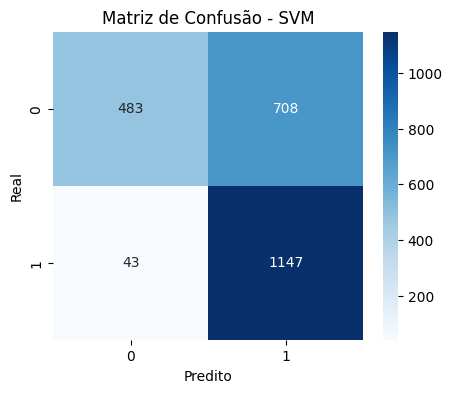

SVM Mudança do parametro C
Resultados para SVM Mudança do parametro C:
Acurácia: 0.7774044519109617
Precision: 0.8067346506706565
Recall: 0.7774044519109617
F1-score: 0.7719725219377478

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.62      0.74      1191
           1       0.71      0.93      0.81      1190

    accuracy                           0.78      2381
   macro avg       0.81      0.78      0.77      2381
weighted avg       0.81      0.78      0.77      2381



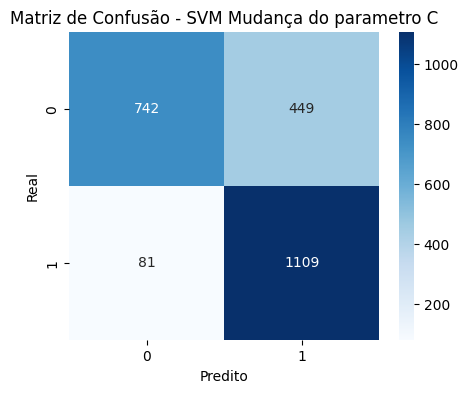

SVM Mudança do parametro Gamma e C
Resultados para SVM Mudança do parametro Gamma e C:
Acurácia: 0.9034019319613608
Precision: 0.9036261549504384
Recall: 0.9034019319613608
F1-score: 0.9033890486561651

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1191
           1       0.89      0.92      0.90      1190

    accuracy                           0.90      2381
   macro avg       0.90      0.90      0.90      2381
weighted avg       0.90      0.90      0.90      2381



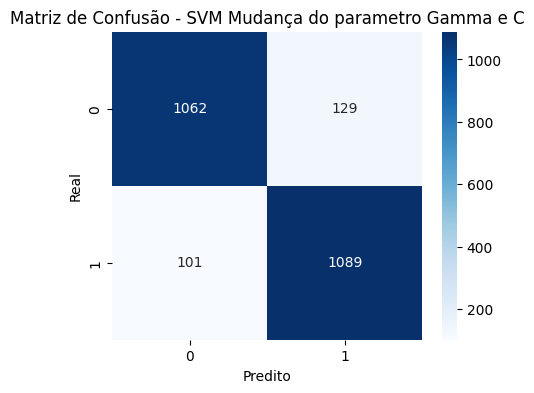

In [14]:
svm_clf = SVC(probability=True)
svm_clf.fit(X_train, y_train)
svm_preds = svm_clf.predict(X_test)
print("SVM Padrão")
evaluate_model(y_test, svm_preds, "SVM")


svm_clf2 = SVC(
  probability=True,      
  C=100.0,        
  class_weight='balanced'
)
svm_clf2.fit(X_train, y_train)
svm_preds2 = svm_clf2.predict(X_test)
print("SVM Mudança do parametro C")
evaluate_model(y_test, svm_preds2, "SVM Mudança do parametro C")


svm_clf3 = SVC(
    probability=True,       
    C=100.0,              
    gamma='auto',         
    class_weight='balanced'
)
svm_clf3.fit(X_train, y_train)
svm_preds3 = svm_clf3.predict(X_test)
print("SVM Mudança do parametro Gamma e C")
evaluate_model(y_test, svm_preds3, "SVM Mudança do parametro Gamma e C")

# Segundo Classificador, Random Forests
## Random Forests são algoritmos de ensemble que combinam várias árvores de decisão, criadas com amostras aleatórias de dados e características, para realizar classificação ou regressão
## O primeiro modelo aqui, não se saio tão mal quanto o primeiro modelo do SVM, porém mesmo variando vários hiper parâmetros o modelo não melhorava significativamente, portanto minha melhor métrica aqui foi com o modelo variando o número de estimators e mantendo o resto padrão, tendo 0.85 de acurácia e 0.85 de precisão

RandomForest
Resultados para RandomForest:
Acurácia: 0.8454430911381773
Precision: 0.8459571102035511
Recall: 0.8454430911381773
F1-score: 0.8453841261007181

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1191
           1       0.86      0.83      0.84      1190

    accuracy                           0.85      2381
   macro avg       0.85      0.85      0.85      2381
weighted avg       0.85      0.85      0.85      2381



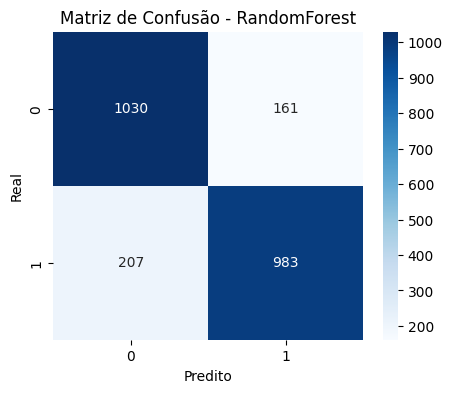

RandomForest variando estimators
Resultados para RandomForest variando estimators:
Acurácia: 0.8509029819403612
Precision: 0.8514482981003841
Recall: 0.8509029819403612
F1-score: 0.8508436257800165

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1191
           1       0.87      0.83      0.85      1190

    accuracy                           0.85      2381
   macro avg       0.85      0.85      0.85      2381
weighted avg       0.85      0.85      0.85      2381



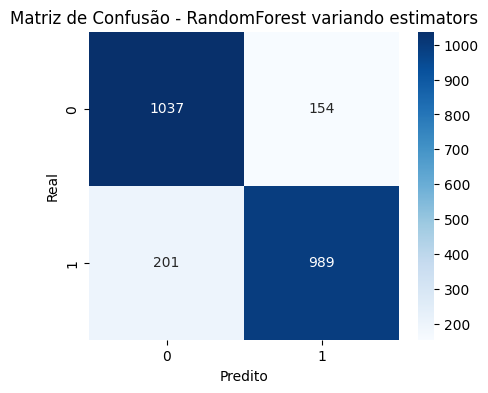

In [15]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)
print("RandomForest")
evaluate_model(y_test, rf_preds, "RandomForest")

rf_clf2 = RandomForestClassifier(n_estimators=500, random_state=42,n_jobs=-1)
rf_clf2.fit(X_train, y_train)
rf_preds2 = rf_clf2.predict(X_test)
print("RandomForest variando estimators")
evaluate_model(y_test, rf_preds2, "RandomForest variando estimators")

# Terceiro Classificador, Logistic Regression
## Logistic Regression é um algoritmo de aprendizado supervisionado usado para classificação binária ou multi-classes, que modela a probabilidade de uma amostra pertencer a uma classe usando a função logística (sigmoide)
## Aqui, aconteceu o mesmo que o random forests, o primeiro modelo se saiu muito bem, porém, nenhum parâmetro que eu variei melhorou a métrica, mas na verdade, diminui os indicadores, portanto minha melhor tentativa foi com o modelo padrão obtendo 0.88 de acurácia e 0.88 de precisão

Logistic Regression
Resultados para Logistic Regression:
Acurácia: 0.887022259554809
Precision: 0.8870447382439419
Recall: 0.887022259554809
F1-score: 0.8870208246883192

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1191
           1       0.88      0.89      0.89      1190

    accuracy                           0.89      2381
   macro avg       0.89      0.89      0.89      2381
weighted avg       0.89      0.89      0.89      2381



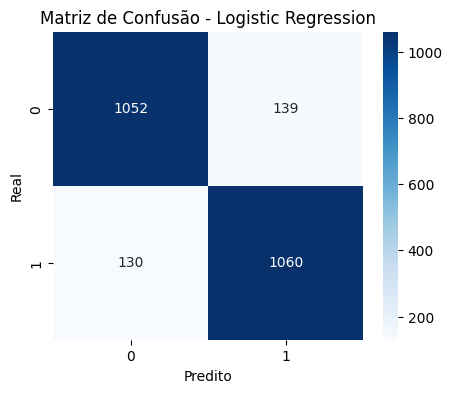

Logistic Regression variando penalty e solver
Resultados para Logistic Regression variando penalty e solver:
Acurácia: 0.8047039059218816
Precision: 0.8059231694366495
Recall: 0.8047039059218816
F1-score: 0.8045125299321976

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1191
           1       0.79      0.84      0.81      1190

    accuracy                           0.80      2381
   macro avg       0.81      0.80      0.80      2381
weighted avg       0.81      0.80      0.80      2381



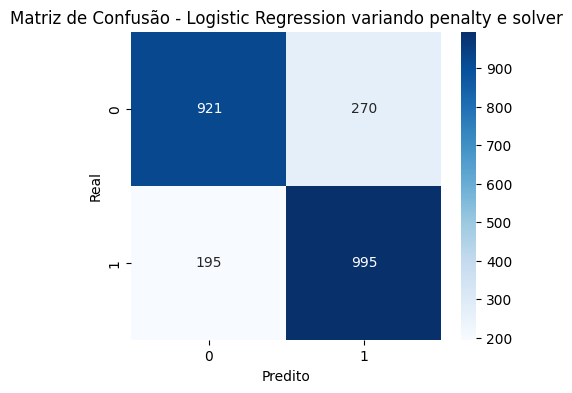

In [16]:
logreg_clf = LogisticRegression(max_iter=10000, random_state=42,n_jobs=-1)
logreg_clf.fit(X_train, y_train)
logreg_preds = logreg_clf.predict(X_test)
print("Logistic Regression")
evaluate_model(y_test, logreg_preds, "Logistic Regression")

logreg_clf3 = LogisticRegression(max_iter=10000, penalty="l2", solver="saga" , random_state=42,n_jobs=-1)
logreg_clf3.fit(X_train, y_train)
logreg_preds3 = logreg_clf3.predict(X_test)
print("Logistic Regression variando penalty e solver")
evaluate_model(y_test, logreg_preds3, "Logistic Regression variando penalty e solver")

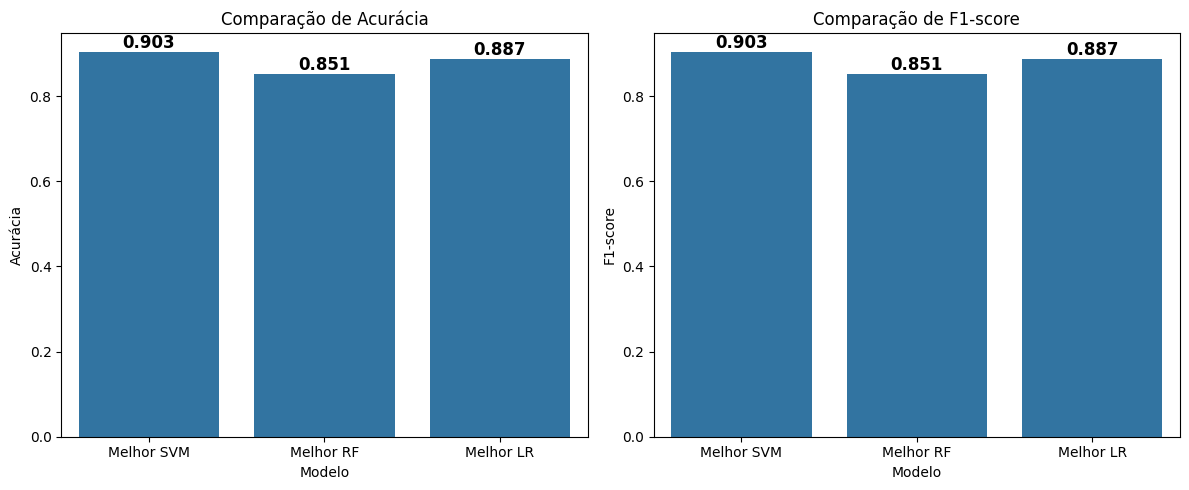

In [20]:
results = {
  'Modelo': ['Melhor SVM', 'Melhor RF', 'Melhor LR'], # RF - Random Forests / LR - Logistic Regression
  'Acurácia': [
    accuracy_score(y_test, svm_preds3),
    accuracy_score(y_test, rf_preds2),
    accuracy_score(y_test, logreg_preds)
  ],
  'F1-score': [
    f1_score(y_test, svm_preds3, average='weighted'),
    f1_score(y_test, rf_preds2, average='weighted'),
    f1_score(y_test, logreg_preds, average='weighted')
  ]
}

df_results = pd.DataFrame(results)

# Criando os gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de Acurácia
sns.barplot(x='Modelo', y='Acurácia', data=df_results, ax=ax[0])
ax[0].set_title("Comparação de Acurácia")

# Adicionando os valores no topo das barras
for i, v in enumerate(df_results['Acurácia']):
    ax[0].text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=12, fontweight='bold')

# Gráfico de F1-score
sns.barplot(x='Modelo', y='F1-score', data=df_results, ax=ax[1])
ax[1].set_title("Comparação de F1-score")

# Adicionando os valores no topo das barras
for i, v in enumerate(df_results['F1-score']):
    ax[1].text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Notamos a partir a observação do gráfico que o melhor modelo para detecção de fake news, usando vetores embedding usados nesses trabalho, me português foi o SVM com a mudança nos parâmetros Gamma e C